## 1. Importing libraries

In [17]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import requests
from pandas.io.json import json_normalize

## 2. Importing datasets

In [18]:
#Reading in data 
## Testing data

#Total tests conducted
df4 = pd.read_csv('./../data/raw/full-list-total-tests-for-covid-19.csv')
sa_tot=df4[df4['Entity'] == 'South Africa']

#Confirmed provincial cummulative  tests         
df5 = pd.read_csv('./../data/raw/owid-covid-data.csv', sep= ',')
sa_cumm=df5[df5['location'] == 'South Africa']

#Confirmed national cummulative confirmed positive tests         
df6 = pd.read_csv('./../data/raw/time_series_covid19_confirmed_global.csv', sep= ',')
sa_con=df6[df6['Country/Region'] == 'South Africa']

#Confirmed national cummulative confirmed deaths         
df7 = pd.read_csv('./../data/raw/time_series_covid19_deaths_global.csv', sep= ',')
sa_death=df7[df7['Country/Region'] == 'South Africa']

#Confirmed national cummulative confirmed revovered tests         
df8 = pd.read_csv('./../data/raw/time_series_covid19_recovered_global.csv', sep= ',')
sa_recovd=df8[df8['Country/Region'] == 'South Africa']

#National density
sa_dens = pd.read_csv('./../data/raw/data.csv')
sa_dens=sa_dens[sa_dens['name'] == 'South Africa']

#Number of hospital beds per province
hosp_beds = pd.read_csv('./../data/raw/hospital_beds.csv', sep = ';')

#List of hospitals in each povince
hosp_list=pd.read_csv("./../data/raw/health_system_za_public_hospitals.csv")

#Government measures dataset
excel_file = './../data/raw/acaps_covid19_government_measures_dataset.xlsx'
df9 = pd.read_excel(excel_file, sheet_name='Database', index_col=0)
sa_gov=df9[df9['COUNTRY'] == 'South Africa']

## 3.EDA

In [19]:
#Dropping unwanted columns
#Confirmed national cummulative tests conducted
sa_gov = sa_gov.drop(['COUNTRY','ISO','ADMIN_LEVEL_NAME','PCODE','REGION'], axis=1)

#Confirmed national cummulative tests conducted
sa_tot = sa_tot.drop(['Entity','Code'], axis=1)

#Confirmed national cummulative tests conducted
sa_dens = sa_dens.drop(['rank'], axis=1)

#List of hospitals
hosp_list = hosp_list.drop(['ID','Lat', 'Long','district','district_estimated_population','subdistrict', 'service_offered_by_hospital', 'size_hospital','number_of_beds','number_of_practitioners','webpage','geo_subdivision'], axis=1)

#Confirmed national cummulative tests conducted
sa_cumm = sa_cumm.drop(['iso_code'], axis=1)

#Confirmed national cummulative confirmed positive tests 
sa_con = sa_con.drop(['Lat', 'Long','Province/State'], axis=1)

#Confirmed national cummulative confirmed deaths 
sa_death = sa_death.drop(['Lat', 'Long','Province/State'], axis=1)

#Confirmed national cummulative confirmed recovered
sa_recovd = sa_recovd.drop(['Lat', 'Long','Province/State'], axis=1)

# Extracting relevant columns
sa_cumm= sa_cumm[['date','new_cases','new_deaths']]

In [20]:
#Cleaning up columns

#Creating date column for sa_con dataframe
dfc1 = sa_con.melt(id_vars=["Country/Region"], 
                    var_name="Date",
                    value_name="cases")
dfc1 = dfc1.rename({'Country/Region': 'country', 'Date': 'date'}, axis=1)
sa_con = dfc1
sa_con['date'] = pd.to_datetime(sa_con['date'])

#Creating date column for sa_death dataframe
dfc2 = sa_death.melt(id_vars=["Country/Region"], 
                    var_name="Date",
                    value_name="cases")
dfc2 = dfc2.rename({'Country/Region': 'country', 'Date': 'date'}, axis=1)
sa_death = dfc2
sa_death['date'] = pd.to_datetime(sa_death['date'])

#Creating date column for sa_recovd dataframe
dfc3 = sa_recovd.melt(id_vars=["Country/Region"], 
                    var_name="Date",
                    value_name="cases")
dfc3 = dfc3.rename({'Country/Region': 'country', 'Date': 'date'}, axis=1)
sa_recovd = dfc3

#converting to datetime
sa_recovd['date'] = pd.to_datetime(sa_recovd['date'])
sa_cumm['date'] = pd.to_datetime(sa_cumm['date'])
sa_tot['Date'] = pd.to_datetime(sa_tot['Date'])
sa_gov['ENTRY_DATE'] = pd.to_datetime(sa_gov['ENTRY_DATE'])
sa_gov['DATE_IMPLEMENTED'] = pd.to_datetime(sa_gov['DATE_IMPLEMENTED'])

#converting all nan values to 0
sa_cumm = sa_cumm.fillna(0)
sa_tot = sa_tot.fillna(0)
sa_gov = sa_gov.fillna(0)

In [21]:
#Renaming testing columns 

sa_tot.rename(columns={'Total tests':'total_tests',
                      'Date':'date'}, inplace=True)
sa_con.rename(columns={'cases':'confirmed_cases'}, inplace=True)
sa_death.rename(columns={'cases':'death_cases'}, inplace=True)
sa_recovd.rename(columns={'cases':'recovered_cases'}, inplace=True)


In [22]:
#Merging South Africa's confirmed, death, recovered cases and new cases for each

sa_testing=pd.merge(sa_con, sa_death, how='left')
sa_testing=pd.merge(sa_testing, sa_recovd, how='left')
sa_testing=pd.merge(sa_testing, sa_cumm, how='left')
sa_testing=pd.merge(sa_testing, sa_tot, how='left')

# Removing nans in dataframe
sa_testing= sa_testing.fillna(0)


In [23]:
#Dropping days whereby they have 0 confirmed cases
sa_testing = sa_testing[sa_testing.confirmed_cases != 0]

In [24]:
#resetting index
sa_testing = sa_testing.reset_index(drop=True)

In [25]:
sa_testing.to_csv(r'./../data/raw/sa_testing.csv', index = False)
# df4 = pd.read_csv('./../data/raw/full-list-total-tests-for-covid-19.csv')


##  4.  Statistical analysis

### 4.1 Testing dataset

In [26]:
#Looking closely into the national testing dataframe

# display of latest figures
totl_test = sa_testing['total_tests'].iloc[-1]
totl_con = sa_testing['confirmed_cases'].iloc[-1]
totl_death = sa_testing['death_cases'].iloc[-1]
totl_recovd = sa_testing['recovered_cases'].iloc[-1]
new_case = sa_testing['new_cases'].iloc[-1]
new_deaths = sa_testing['new_deaths'].iloc[-1]
date = sa_testing['date'].iloc[-1]

print('Date:{} TOTAL TESTED:{} TOTAL CASES:{} TOTAL DEATH:{} TOTAL RECOVERED:{} NEW CASES:{}' .format(date,totl_test,totl_con,totl_death,totl_recovd,new_case), sep='nl')


Date:2020-05-11 00:00:00 TOTAL TESTED:356067.0 TOTAL CASES:10652 TOTAL DEATH:206 TOTAL RECOVERED:4357 NEW CASES:595.0


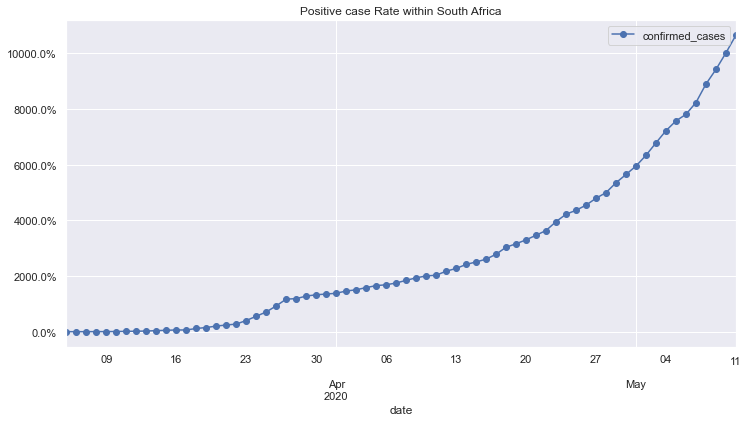

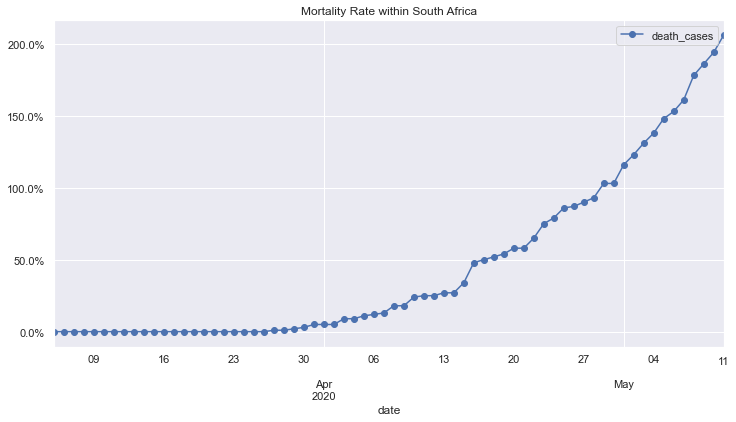

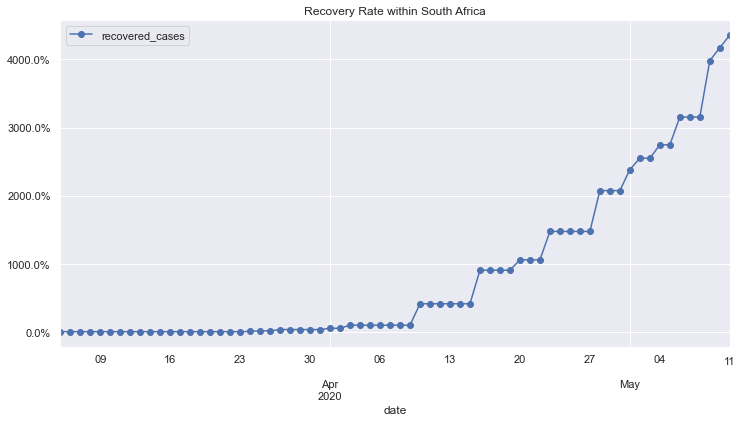

In [27]:
#Rate calculating confirmed cases
sa_testing['positive_rate'] = sa_testing['confirmed_cases'] / sa_testing['total_tests']

ax = sa_testing.plot(x='date',y='confirmed_cases', grid=True, figsize=(12, 6), marker='o', title='Positive case Rate within South Africa')
plt.gca().set_yticklabels(['{:.1f}%'.format(x*1) for x in plt.gca().get_yticks()]) 
plt.show()

#Rate calculating death cases
sa_testing['mortality_rate'] = sa_testing['death_cases'] / sa_testing['total_tests']

ax = sa_testing.plot(x='date', y='death_cases', grid=True, figsize=(12, 6), marker='o', title='Mortality Rate within South Africa')
plt.gca().set_yticklabels(['{:.1f}%'.format(x*1) for x in plt.gca().get_yticks()]) 
plt.show()

#Rate calculating recovered cases
sa_testing['recovery_rate'] = sa_testing['recovered_cases'] / sa_testing['total_tests']

ax = sa_testing.plot(x='date',y='recovered_cases', grid=True, figsize=(12, 6), marker='o', title='Recovery Rate within South Africa')
plt.gca().set_yticklabels(['{:.1f}%'.format(x*1) for x in plt.gca().get_yticks()]) 
plt.show()

In [28]:
#Moving averages for total tests cases for 7,14,21 and 28 days
sa_testing['testing_MA_7'] = sa_testing.total_tests.rolling(7).mean()
sa_testing['testing_MA_14'] = sa_testing.total_tests.rolling(14).mean()
sa_testing['testing_MA_21'] = sa_testing.total_tests.rolling(21).mean()
sa_testing['testing_MA_28'] = sa_testing.total_tests.rolling(28).mean()

#Moving averages for confirmed cases for 7,14,21 and 28 days
sa_testing['confirmed_MA_7'] = sa_testing.confirmed_cases.rolling(7).mean()
sa_testing['confirmed_MA_14'] = sa_testing.confirmed_cases.rolling(14).mean()
sa_testing['confirmed_MA_21'] = sa_testing.confirmed_cases.rolling(21).mean()
sa_testing['confirmed_MA_28'] = sa_testing.confirmed_cases.rolling(28).mean()


#Moving averages for death cases for 7,14,21 and 28 days
sa_testing['death_MA_7'] = sa_testing.death_cases.rolling(7).mean()
sa_testing['death_MA_14'] = sa_testing.death_cases.rolling(14).mean()
sa_testing['death_MA_21'] = sa_testing.death_cases.rolling(21).mean()
sa_testing['death_MA_28'] = sa_testing.death_cases.rolling(28).mean()

#Moving averages for recovered cases for 7,14,21 and 28 days
sa_testing['recoverd_MA_7'] = sa_testing.recovered_cases.rolling(7).mean()
sa_testing['recoverd_MA_14'] = sa_testing.recovered_cases.rolling(14).mean()
sa_testing['recoverd_MA_21'] = sa_testing.recovered_cases.rolling(21).mean()
sa_testing['recoverd_MA_28'] = sa_testing.recovered_cases.rolling(28).mean()


# Removing nans in dataframe
sa_testing= sa_testing.fillna(0)

In [29]:
# Create traces for confirmed cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['confirmed_cases'],
                    mode='markers',
                    name='Total cummulative tests'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['confirmed_MA_7'],
                    mode='markers',
                    name='7 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['confirmed_MA_14'],
                    mode='markers',
                    name='14 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['confirmed_MA_21'],
                    mode='markers',
                    name='21 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['confirmed_MA_28'],
                    mode='markers',
                    name='28 Day moving average'))

# Edit the layout
fig.update_layout(title='National confirmed cases',
                   xaxis_title='Days',
                   yaxis_title='Confirmed cases')

fig.show()

# Create traces for death cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['death_cases'],
                    mode='markers',
                    name='Total death cases'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['death_MA_7'],
                    mode='markers',
                    name='7 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['death_MA_14'],
                    mode='markers',
                    name='14 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['death_MA_21'],
                    mode='markers',
                    name='21 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['death_MA_28'],
                    mode='markers',
                    name='28 Day moving average'))

# Edit the layout
fig.update_layout(title='National death cases',
                   xaxis_title='Days',
                   yaxis_title='Death cases')

fig.show()

# Create traces for recovered cases
fig = go.Figure()
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['recovered_cases'],
                    mode='markers',
                    name='Total recovered cases'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['recoverd_MA_7'],
                    mode='markers',
                    name='7 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['recoverd_MA_14'],
                    mode='markers',
                    name='14 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['recoverd_MA_21'],
                    mode='markers',
                    name='21 Day moving average'))
fig.add_trace(go.Scatter(x=sa_testing['date'], y=sa_testing['recoverd_MA_28'],
                    mode='markers',
                    name='28 Day moving average'))

# Edit the layout
fig.update_layout(title='National recovered cases',
                   xaxis_title='Days',
                   yaxis_title='Recovered cases')

fig.show()

### 4.2 Hospital dataset

In [30]:
#Looking closely into the national hospital dataframe

fig = px.bar(hosp_beds, x='Province', y='Total no of beds',
             hover_data=['No of public hospitals', 'No of private hospitals'],
             labels={'Number of hospital beds nationally'}, height=400)
fig.show()

### 4.3 Density dataframe

In [31]:
#Looking closely into the national density dataframe

# display of latest figures
density = sa_dens['density'].iloc[-1]
dens_mi = sa_dens['densityMi'].iloc[-1]
pop_2020 = sa_dens['pop2020'].iloc[-1]
area = sa_dens['area'].iloc[-1]

print('Population density:{} Population:{} Area(km2):{} ' .format(density,pop_2020,area), sep='nl')


Population density:48.5724 Population:59308.69 Area(km2):1221037.0 


### 4.4 SA Government measures dataset

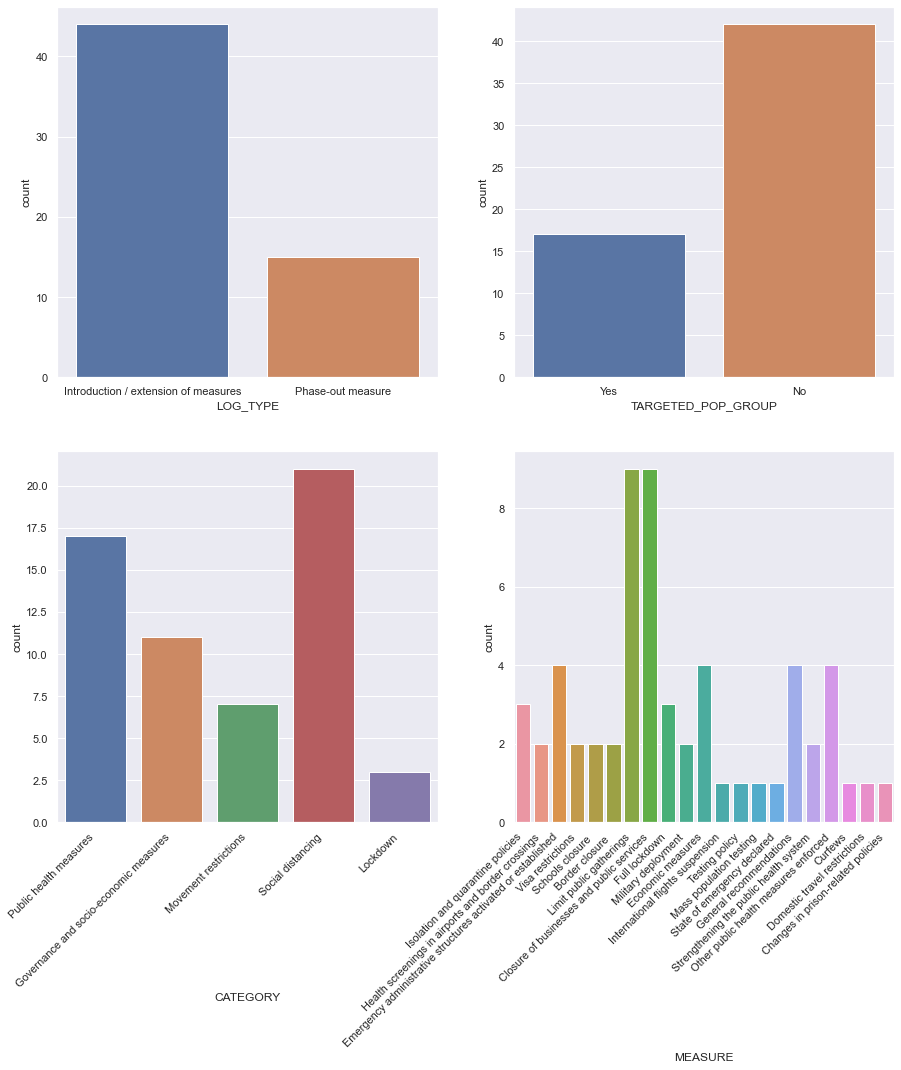

In [32]:
#Looking closely into the national hospital dataframe
sns.set(style="darkgrid")

fig, axes = plt.subplots(2,2, figsize=(15, 15))
fx=sns.countplot(x = 'LOG_TYPE', ax=axes[0, 0], data = sa_gov)
gx=sns.countplot(x = 'CATEGORY', ax=axes[1, 0], data = sa_gov)
fc=sns.countplot(x = 'TARGETED_POP_GROUP', ax=axes[0,1], data = sa_gov)
hn=sns.countplot(x = 'MEASURE', ax=axes[1,1], data = sa_gov)


gx.set_xticklabels(
    gx.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light')

hn.set_xticklabels(
    hn.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light');